Elit Jasmine Dogu (ejd5mm)       
DS 5001    
5 May 2021    
*Third year, Undergraduate Student*     



# What This File Contains: 
- Tokenizing and Annotating with NLTK
- Creating Token-Time Matrix
- Visualizing Dispersion Plots of Words
- Doing it Again but Better with Seaborn Strip Plots
- Using KDE
    -Creating Arrays of Offsets for Each Term
- Visualizing the KDE Plots
- Annotating Vocabulary Table with Stopwords
- Adding Stems to Vocabulary Table
    - Looking at Most Frequent stem_porter
        - Exploring the Top Three 
    - Looking at Most Frequent stem_snowball
        - Exploring the Top Three 
    - Looking at Most Frequent stem_lancaster
         - Exploring the Top Three 


# HW 4 below

In [1]:
import dill 
dill.load_session('notebook_env_file3.db') #loading in all of the tables and everything in the environment of File3.ipynb

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import matplotlib.pyplot as pla

In [3]:
#creating subdirectories
data_in = './data_in'
#data_in_lf ='./data_out/file3' 
data_out = './data_out/file4'

## Tokenize and Annotate

We use NLTK this time. Note that this process takes some time, mainly because the NLTK functions are not optimized for dataframes.


In [4]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num'] #defining an OHCO structure

In [5]:
def tokenize(doc_df, OHCO=OHCO, remove_pos_tuple=False, ws=False):
    
    # Paragraphs to Sentences
    df = doc_df.para_str\
        .apply(lambda x: pd.Series(nltk.sent_tokenize(x)))\
        .stack()\
        .to_frame()\
        .rename(columns={0:'sent_str'})
    
    # Sentences to Tokens
    # Local function to pick tokenizer
    def word_tokenize(x):
        if ws:
            s = pd.Series(nltk.pos_tag(nltk.WhitespaceTokenizer().tokenize(x)))
        else:
            s = pd.Series(nltk.pos_tag(nltk.word_tokenize(x))) # Discards stuff in between
        return s
            
    df = df.sent_str\
        .apply(word_tokenize)\
        .stack()\
        .to_frame()\
        .rename(columns={0:'pos_tuple'})
    
    # Grab info from tuple
    df['pos'] = df.pos_tuple.apply(lambda x: x[1])
    df['token_str'] = df.pos_tuple.apply(lambda x: x[0])
    if remove_pos_tuple:
        df = df.drop('pos_tuple', 1)
    
    # Add index
    df.index.names = OHCO
    
    return df

In [6]:
#dfp = pd.read_csv('{}/Great-Gatsby-GROUP-LINES-BY-PARAGRAPH.csv'.format(data_in_lf))
DOC = dfp.copy()
DOC['book_id'] = 'Great Gatsby'
#DOC = DOC.reset_index(drop = True)

In [7]:
DOC

para_str  \
chap_num para_num                                                      
1        0         In my younger and more vulnerable years my fat...   
         1         that I’ve been turning over in my mind ever si...   
         2         “Whenever you feel like criticizing anyone,” h...   
         3         remember that all the people in this world hav...   
         4                                         that you’ve had.”   
...                                                              ...   
9        494       year recedes before us. It eluded us then, but...   
         495       matter—tomorrow we will run faster, stretch ou...   
         496                                       one fine morning—   
         497       So we beat on, boats against the current, born...   
         498                                               the past.   

                        book_id  
chap_num para_num                
1        0         Great Gatsby  
         1         Great Gatsby  
         2         Great Gatsby  
         3         Great Gatsby  
         4         Great Gatsby  
...                         ...  
9        494       Great Gatsby  
         495       Great Gatsby  
         496       Great Gatsby  
         497       Great Gatsby  
         498       Great Gatsby  

[4709 rows x 2 columns]

In [8]:
TOKEN_NLTK_ANNOTATED = tokenize(DOC, ws=False)

In [9]:
TOKEN_NLTK_ANNOTATED

pos_tuple   pos    token_str
chap_num para_num sent_num token_num                                      
1        0        0        0                   (In, IN)    IN           In
                           1                 (my, PRP$)  PRP$           my
                           2             (younger, JJR)   JJR      younger
                           3                  (and, CC)    CC          and
                           4                (more, RBR)   RBR         more
...                                                 ...   ...          ...
9        497      0        12         (ceaselessly, RB)    RB  ceaselessly
                           13                (into, IN)    IN         into
         498      0        0                  (the, DT)    DT          the
                           1                 (past, NN)    NN         past
                           2                     (., .)     .            .

[61066 rows x 3 columns]

In [10]:
TOKEN_NLTK_ANNOTATED[TOKEN_NLTK_ANNOTATED.pos.str.match('^NNP')]

pos_tuple  pos token_str
chap_num para_num sent_num token_num                              
1        3        0        9               (’, NNP)  NNP         ’
         26       1        6            (East, NNP)  NNP      East
         29       1        1          (Gatsby, NNP)  NNP    Gatsby
         37       0        3               (”, NNP)  NNP         ”
                           4             (—it, NNP)  NNP       —it
...                                             ...  ...       ...
9        487      0        1               (’, NNP)  NNP         ’
         488      0        0           (Daisy, NNP)  NNP     Daisy
                           1               (’, NNP)  NNP         ’
         493      0        0          (Gatsby, NNP)  NNP    Gatsby
         494      1        7               (’, NNP)  NNP         ’

[3338 rows x 3 columns]

We can look at particular part of speech tags that we are intereested in. For example, in the cell above we are looking at NNP.

In [11]:
print(type(TOKEN_NLTK_ANNOTATED))

<class 'pandas.core.frame.DataFrame'>


In [12]:
BOOK = TOKEN_NLTK_ANNOTATED.copy()

In [13]:
#normalize 
BOOK['term_str'] = BOOK['token_str'].str.lower().str.replace(r'[\W_]', '').dropna()
BOOK['term_id'] = 100

/Users/jasminedogu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [14]:
BOOK

pos_tuple   pos    token_str  \
chap_num para_num sent_num token_num                                         
1        0        0        0                   (In, IN)    IN           In   
                           1                 (my, PRP$)  PRP$           my   
                           2             (younger, JJR)   JJR      younger   
                           3                  (and, CC)    CC          and   
                           4                (more, RBR)   RBR         more   
...                                                 ...   ...          ...   
9        497      0        12         (ceaselessly, RB)    RB  ceaselessly   
                           13                (into, IN)    IN         into   
         498      0        0                  (the, DT)    DT          the   
                           1                 (past, NN)    NN         past   
                           2                     (., .)     .            .   

                                         term_str  term_id  
chap_num para_num sent_num token_num                        
1        0        0        0                   in      100  
                           1                   my      100  
                           2              younger      100  
                           3                  and      100  
                           4                 more      100  
...                                           ...      ...  
9        497      0        12         ceaselessly      100  
                           13                into      100  
         498      0        0                  the      100  
                           1                 past      100  
                           2                           100  

[61066 rows x 5 columns]

## Create Token-Time Matrix

In [15]:
TTM = pd.get_dummies(BOOK['term_str'], columns=['term_str'], prefix='', prefix_sep='', drop_first=True)\
    .reset_index(drop=True).iloc[:,1:]
TTM.index.name = 'time_id'

In [16]:
cfg = {'figsize': (20,1)}

In [17]:
DOC.to_csv('{}/Great-Gatsby-DOC.csv'.format(data_out), index=True)
BOOK.to_csv('{}/Great-Gatsby-TOKEN-NLTK-ANNOTATED.csv'.format(data_out), index=True)

## Visualize Dispersion Plots of Words

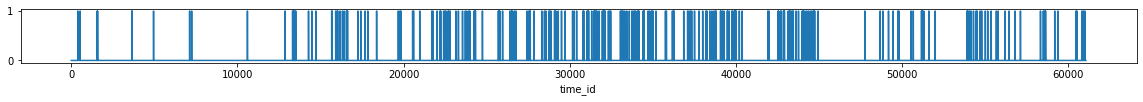

In [18]:
TTM['gatsby'].plot(**cfg);

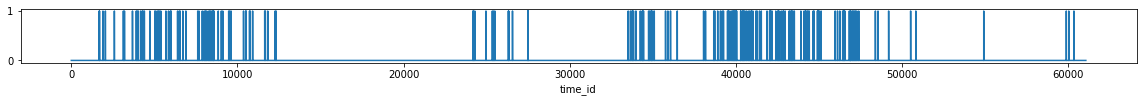

In [19]:
TTM['tom'].plot(**cfg);

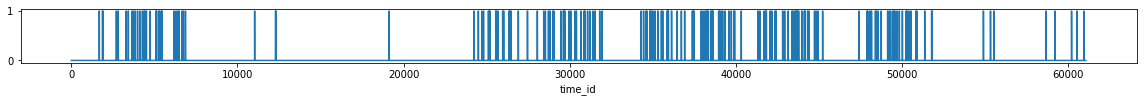

In [20]:
TTM['daisy'].plot(**cfg);

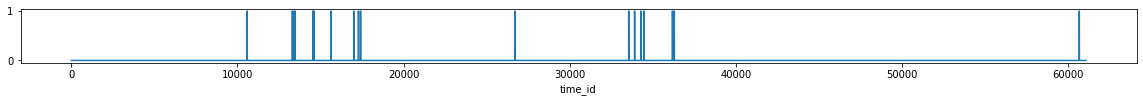

In [21]:
TTM['party'].plot(**cfg);

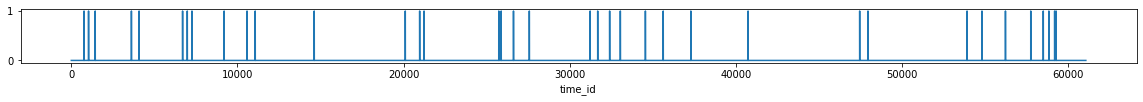

In [22]:
TTM['west'].plot(**cfg);

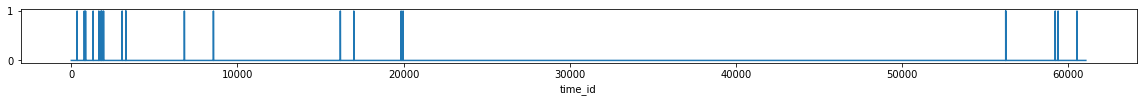

In [23]:
TTM['east'].plot(**cfg);

Above, we can see the dispersion plots of words within the novel. I decided to include the top three characters as well as three terms I felt were relevaant to the novel. We explore this deeper in the paper and below.

## Doing Better with Seaborn Strip Plots

In [24]:
B = BOOK['term_str'].reset_index(drop=True).to_frame().reset_index().rename(columns={'index':'offset'})

In [25]:
OHCO = "book_id chap_num para_num sent_num token_num".split()
book_str = 'Gatsby'
#data_dir1 = "./data_in"
#data_dir2 = "./data_out"
#data_prefix = 'austen-melville'

In [26]:
sns.set()
%matplotlib inline

In [27]:
def plot_words(words, book):    
    X = book[book.term_str.isin(words)]
    plt.figure(figsize=(22, len(words)))
    ax = sns.stripplot(y='term_str', x='offset', data=X, orient='h', marker=".", color='navy', size=15, jitter=0)
    ax.set_title('Dispersion Plots', size=30, pad=20)
    ax.set_xlabel('Narrative Time', size=20)
    ax.set_ylabel('Token', size=20)
    plt.xticks(rotation=0, fontsize=20)
    plt.yticks(rotation=0, fontsize=20)
    plt.tight_layout()
    plt.savefig('./data_out/file4/dispersion-plot')
    plt.show()

In [28]:
names = 'daisy nick gatsby tom myrtle jordan wilson'.split()

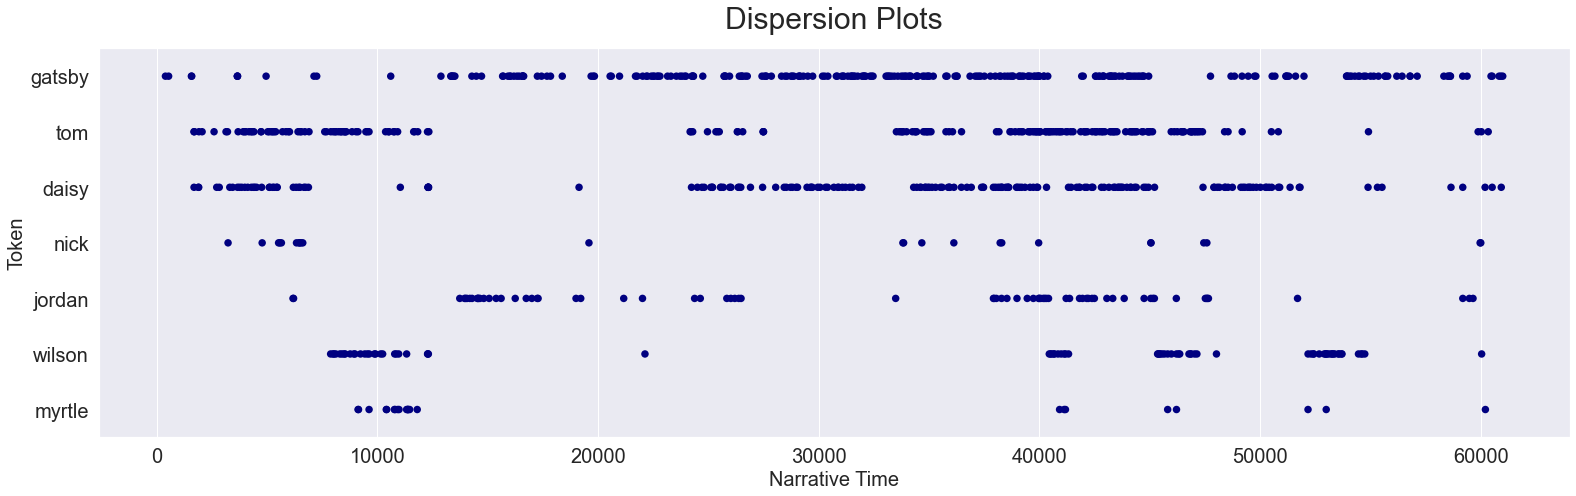

In [29]:
plot_words(names, B)


This Dispersion Plot shows the appearance of all the characters in the novel over narrative time. The paper goes into more depth on this.

## Using KDE

KDE works by positing that each instance of a token represents a small gaussian distribution before and after the word. When words appear in bunches, their curves add up, producing an aggregate curve over narrative time.

In [30]:
kde_kernel = 'gaussian'
kde_bandwidth = 2000
kde_samples = 1000

In [31]:
import numpy as np
import scipy as sp
from sklearn.neighbors import KernelDensity as KDE
from nltk.corpus import stopwords

### Create arrays of offsets for each term

In [32]:
X = B.reset_index().groupby(['term_str']).offset.apply(lambda x: x.tolist()).to_frame()

In [33]:
X['x'] = X.apply(lambda x: np.array(x.offset)[:, np.newaxis], 1)

In [34]:
X.head()

,offset,x
term_str,,
,"[15, 25, 26, 33, 34, 38, 39, 50, 57, 60, 61, 6...","[[15], [25], [26], [33], [34], [38], [39], [50..."
12,[58080],[[58080]]
158th,[9203],[[9203]]
1902,[32908],[[32908]]
1906,[58082],[[58082]]


## KDE for Each Term

In [35]:
scale_max = B.offset.max() # THIS IS CRUCIAL
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
X['kde'] = X.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
X['scores'] = X.apply(lambda row: row.kde.score_samples(x_axis), axis=1)
# B['scaled'] = B.apply(lambda row: np.exp(row.scores) * (scale_max / kde_samples), axis=1)

## Visualize KDE Plots

In [36]:
PLOTS = X.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1)

In [37]:
FIG = dict(figsize=(15, 5))

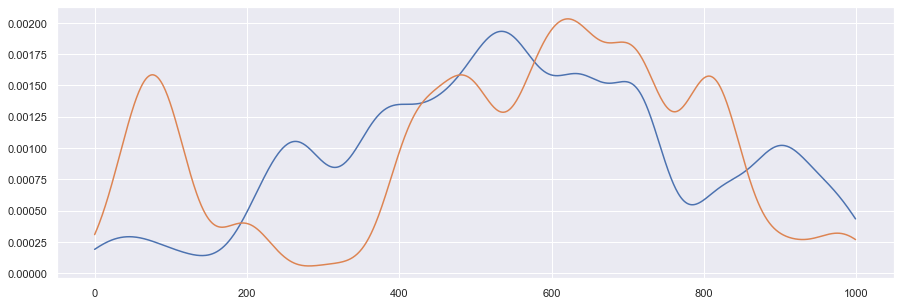

In [38]:
PLOTS.loc['gatsby'].plot(**FIG);
PLOTS.loc['daisy'].plot(**FIG);

plt.savefig('./data_out/file4/gatsby-daisy')


Here, we see Gatsby and Daisy's presence in the novel over narrative time.

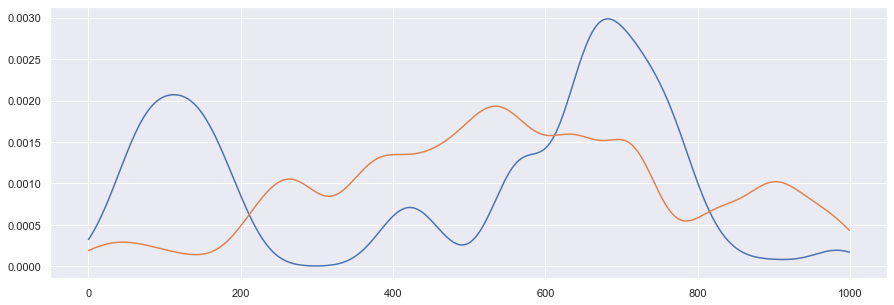

In [39]:
PLOTS.loc['tom'].plot(**FIG);
PLOTS.loc['gatsby'].plot(**FIG);
plt.savefig('./data_out/file4/gatsby-tom')


Here, we see Tom and Gatsby's presence in the novel over narrative time.

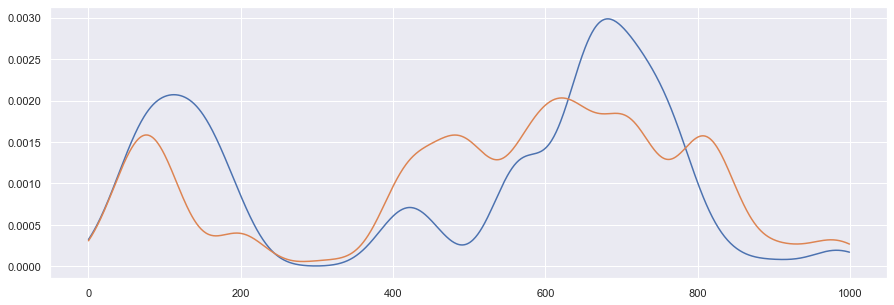

In [40]:
PLOTS.loc['tom'].plot(**FIG);
PLOTS.loc['daisy'].plot(**FIG);
plt.savefig('./data_out/file4/tom-daisy')


Here, we see Tom and Daisy's presence in the novel over narrative time.

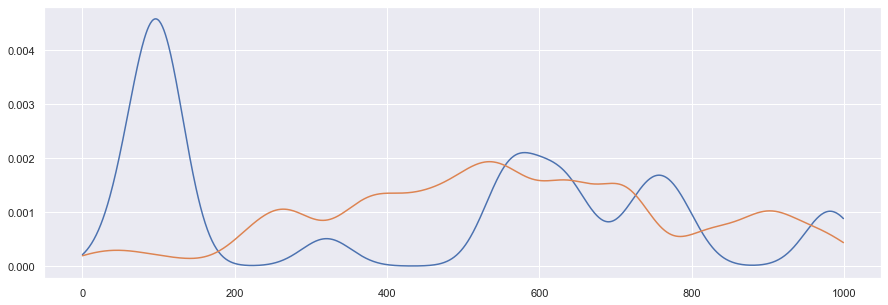

In [41]:
PLOTS.loc['nick'].plot(**FIG);
PLOTS.loc['gatsby'].plot(**FIG);
plt.savefig('./data_out/file4/gatsby-nick')


Here, we see Gatsby and Nick's presence in the novel over narrative time.

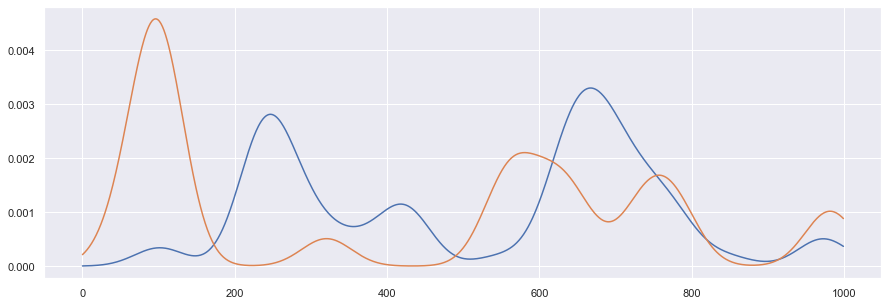

In [42]:
PLOTS.loc['jordan'].plot(**FIG);
PLOTS.loc['nick'].plot(**FIG);
plt.savefig('./data_out/file4/jordan-nick')


Here, we see Nick and Jordans's presence in the novel over narrative time.

In [43]:
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num'] #defining an OHCO structure

In [44]:
TOKEN_NLTK_ANNOTATED['term_str'] = TOKEN_NLTK_ANNOTATED['token_str'].str.lower().str.replace('[\W_]', '')
VOCAB_FROM_NLTK = TOKEN_NLTK_ANNOTATED.term_str.value_counts().to_frame()\
    .rename(columns={'index':'term_str', 'term_str':'n'})\
    .sort_index().reset_index().rename(columns={'index':'term_str'})
VOCAB_FROM_NLTK.index.name = 'term_id'
VOCAB_FROM_NLTK['num'] = VOCAB_FROM_NLTK.term_str.str.match("\d+").astype('int')

/Users/jasminedogu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [45]:
VOCAB_FROM_NLTK

,term_str,n,num
term_id,,,
0,,11722,0
1,12,1,1
2,158th,1,1
3,1902,1,1
4,1906,1,1
...,...,...,...
6147,yours,2,0
6148,yourself,7,0
6149,youth,4,0


In [46]:
VOCAB_FROM_NLTK.to_csv('{}/Great-Gatsby-VOCAB-NLTK.csv'.format(data_out), index=True)

## Annotating VOCAB Table (Stopwords)

In [47]:
#annotate
##add stop words to VOCAB table

sw = pd.DataFrame(nltk.corpus.stopwords.words('english'), columns=['term_str'])
sw = sw.reset_index().set_index('term_str')
sw.columns = ['dummy']
sw.dummy = 1

VOCAB_FROM_NLTK['stop'] = VOCAB_FROM_NLTK.term_str.map(sw.dummy)
VOCAB_FROM_NLTK['stop'] = VOCAB_FROM_NLTK['stop'].fillna(0).astype('int')
#identifying stop words 
#allows us to filter to with stop words or without 

In [48]:
VOCAB_FROM_NLTK[VOCAB_FROM_NLTK.stop == 0].sample(10) #looking at a random sample to see if done correctly, 0 is no to stop words, 1 is yes to stop words

,term_str,n,num,stop
term_id,,,,
1116,consider,1,0,0
3545,named,9,0,0
1517,disquieting,2,0,0
165,allexcept,1,0,0
2620,hinted,1,0,0
5592,trinity,1,0,0
5836,vista,1,0,0
1616,drill,1,0,0
2560,heat,14,0,0


## Adding Stems to VOCAB Table

NOTE: a lot of these stems have ties for the top three count. This means that everytime the notebook is run, the order of the stems with the same count may be different. Therefore, the captions may not match what the table is saying. This does not mean that the caption is wrong however, 

In [49]:
# adding stems to VOCAB table 

#add stems
#from nltk.stem.porter import PorterStemmer
#stemmer = PorterStemmer()
#VOCAB2['p_stem'] = VOCAB2.term_str.apply(stemmer.stem)
#stemmer function called for every word, resulting stem is called p_stem 
#VOCAB2


from nltk.stem.porter import PorterStemmer
stemmer1 = PorterStemmer()
VOCAB_FROM_NLTK['stem_porter'] = VOCAB_FROM_NLTK.term_str.apply(stemmer1.stem)

from nltk.stem.snowball import SnowballStemmer
stemmer2 = SnowballStemmer("english")
VOCAB_FROM_NLTK['stem_snowball'] = VOCAB_FROM_NLTK.term_str.apply(stemmer2.stem)

from nltk.stem.lancaster import LancasterStemmer
stemmer3 = LancasterStemmer()
VOCAB_FROM_NLTK['stem_lancaster'] = VOCAB_FROM_NLTK.term_str.apply(stemmer3.stem)
VOCAB_FROM_NLTK

,term_str,n,num,stop,stem_porter,stem_snowball,stem_lancaster
term_id,,,,,,,
0,,11722,0,0,,,
1,12,1,1,0,12,12,12
2,158th,1,1,0,158th,158th,158th
3,1902,1,1,0,1902,1902,1902
4,1906,1,1,0,1906,1906,1906
...,...,...,...,...,...,...,...
6147,yours,2,0,1,your,your,yo
6148,yourself,7,0,1,yourself,yourself,yourself
6149,youth,4,0,0,youth,youth,you


In [50]:
## Creating pos_max column in VOCAB table

In [51]:
pos_max = TOKEN_NLTK_ANNOTATED.groupby('term_str')['pos'].apply(lambda x: x.value_counts().head(1)) #adding pos_max to VOCAB table
df_pos = pos_max.to_frame() #setting to frame
df_pos = df_pos.reset_index() #resetting the index 
df_pos.columns = ['term_str',"pos_max",'count']
df_pos

,term_str,pos_max,count
0,,.,3360
1,12,CD,1
2,158th,CD,1
3,1902,CD,1
4,1906,CD,1
...,...,...,...
6147,yours,NNS,2
6148,yourself,PRP,7
6149,youth,NN,4
6150,youwhy,NN,1


In [52]:
merge_df = df_pos.merge(VOCAB_FROM_NLTK, how = "left", on = "term_str")
merge_df.head()

,term_str,pos_max,count,n,num,stop,stem_porter,stem_snowball,stem_lancaster
0,,.,3360,11722,0,0,,,
1,12,CD,1,1,1,0,12,12,12
2,158th,CD,1,1,1,0,158th,158th,158th
3,1902,CD,1,1,1,0,1902,1902,1902
4,1906,CD,1,1,1,0,1906,1906,1906


In [53]:
merge_df.to_csv('{}/Great-Gatsby-VOCAB-STEM.csv'.format(data_out))

### Most Frequent stem_porter

In the field of Natural Language Processing, stemming is a process that allows for words to be processed for further processing. Specifically, by going through the process of stemming, a word is reduced to its word stem/root form. Below we will look at the p_stems of the novel. 

In [54]:
most_freq = merge_df["stem_porter"].groupby(merge_df['stem_porter']).count().sort_values(ascending=False) #finding most common p_stem 
#most_freq
#the top two p_stems do not change when we include non typical chapters like prelude, finale, etc.

In [55]:
#got help from Professor Alvarado on this...
porter = merge_df.groupby('stem_porter')
STEMP = porter.stem_porter.count().sort_values(ascending = False).to_frame('n')
STEMP['terms'] = porter.apply(lambda x: ' '.join(x.term_str)).to_frame('')
STEMP

,n,terms
stem_porter,,
gener,8,general generalities generalized generally gen...
blind,5,blind blinded blinding blindness blinds
happen,5,happen happened happening happenings happens
play,5,play played playfully playing plays
care,5,care cared careful carefully cares
...,...,...
gloriou,1,glorious
gnaw,1,gnawings
goat,1,goats


In [56]:
STEMP.to_csv('{}/Great-Gatsby-STEM-PORTER.csv'.format(data_out))

In [57]:
STEMP[STEMP['n']==5]

,n,terms
stem_porter,,
blind,5,blind blinded blinding blindness blinds
happen,5,happen happened happening happenings happens
play,5,play played playfully playing plays
care,5,care cared careful carefully cares
remark,5,remark remarkable remarked remarking remarks
love,5,love loved lovely loves loving
murmur,5,murmur murmured murmuring murmurous murmurs


Looking at the table created, the top three Porter stems that have the most term variants are as follows:
- gener, which appeared 8 times
- love, which appeared 5 times 
- blind, which appeared 5 times 

It is important to note that there are 7 different stemp_porter's that have n counts of 5, which was the second highest n count. These include the stem_porter values love, blind, murmur, care, happen, remark, and play. The top three were selected based off of the table created above, which sorted the values in descending value. Analyzing all oof the stem_porters with a value of 5 could be important as they all play a different critical role.

#### Exploring the Top Three stem_porter

In [58]:
gener = merge_df[merge_df['stem_porter']== "gener"]
gener

,term_str,pos_max,count,n,num,stop,stem_porter,stem_snowball,stem_lancaster
2283,general,JJ,1,2,0,0,gener,general,gen
2284,generalities,NNS,1,1,0,0,gener,general,gen
2285,generalized,JJ,1,1,0,0,gener,general,gen
2286,generally,RB,2,2,0,0,gener,general,gen
2287,generating,VBG,1,1,0,0,gener,generat,gen
2288,generation,NN,2,2,0,0,gener,generat,gen
2289,generations,NNS,1,1,0,0,gener,generat,gen
2290,generous,JJ,1,1,0,0,gener,generous,gen


In [59]:
gener.term_str.to_list()

['general',
 'generalities',
 'generalized',
 'generally',
 'generating',
 'generation',
 'generations',
 'generous']

In [60]:
love = merge_df[merge_df['stem_porter']== "love"]
love

,term_str,pos_max,count,n,num,stop,stem_porter,stem_snowball,stem_lancaster
3233,love,NN,12,24,0,0,love,love,lov
3234,loved,VBD,15,19,0,0,love,love,lov
3235,lovely,JJ,5,10,0,0,love,love,lov
3236,loves,VBZ,3,3,0,0,love,love,lov
3237,loving,VBG,1,1,0,0,love,love,lov


In [61]:
love.term_str.to_list()

['love', 'loved', 'lovely', 'loves', 'loving']

In [62]:
blind = merge_df[merge_df['stem_porter']== "blind"]
blind

,term_str,pos_max,count,n,num,stop,stem_porter,stem_snowball,stem_lancaster
557,blind,NN,3,5,0,0,blind,blind,blind
558,blinded,VBN,1,1,0,0,blind,blind,blind
559,blinding,VBG,1,1,0,0,blind,blind,blind
561,blindness,NN,1,1,0,0,blind,blind,blind
562,blinds,NNS,2,2,0,0,blind,blind,blind


In [63]:
blind.term_str.to_list()

['blind', 'blinded', 'blinding', 'blindness', 'blinds']

### Most Frequent stem_snowball

In [64]:
most_freq2 = merge_df["stem_snowball"].groupby(merge_df['stem_snowball']).count().sort_values(ascending=False) #finding most common p_stem 
#most_freq2
#the top two p_stems do not change when we include non typical chapters like prelude, finale, etc.

In [65]:
snowball = merge_df.groupby('stem_snowball')
STEMP2 = snowball.stem_snowball.count().sort_values(ascending = False).to_frame('n')
STEMP2['terms'] = snowball.apply(lambda x: ' '.join(x.term_str)).to_frame('')
STEMP2

,n,terms
stem_snowball,,
blind,6,blind blinded blinding blindly blindness blinds
excit,6,excite excited excitedly excitement exciting e...
love,5,love loved lovely loves loving
happen,5,happen happened happening happenings happens
reassur,5,reassurance reassure reassured reassuring reas...
...,...,...
goldturn,1,goldturning
golf,1,golf
golflink,1,golflinks


In [66]:
STEMP2[STEMP2['n']==5]

,n,terms
stem_snowball,,
love,5,love loved lovely loves loving
happen,5,happen happened happening happenings happens
reassur,5,reassurance reassure reassured reassuring reas...
play,5,play played playfully playing plays
care,5,care cared careful carefully cares
remark,5,remark remarkable remarked remarking remarks
murmur,5,murmur murmured murmuring murmurous murmurs


Looking at the table created, the top three stem_snowball values that have the most term variants are as follows:
- blind, which appeared 6 times
- excit, which appeared 6 times 
- love, which appeared 5 times 

It is important to note that there are 7 different stem_snowball's that have n counts of 5, which was the second highest n count. These include the stem_snowball values of remark, murmur, care, reassur, happen, and play. Again, the top three were selected based off of the table created above, which sorted the values in descending value. Analyzing all of the stem_snowball with a value of 5 could be important as they all play a different critical role.

Love, blind, murmur, and care were also found to be frequent stems when using stem_porter as they were with stem_snowball.  

#### Exploring the Top Three stem_snowball

In [67]:
blind_snowball = merge_df[merge_df['stem_snowball']== "blind"]
blind_snowball

,term_str,pos_max,count,n,num,stop,stem_porter,stem_snowball,stem_lancaster
557,blind,NN,3,5,0,0,blind,blind,blind
558,blinded,VBN,1,1,0,0,blind,blind,blind
559,blinding,VBG,1,1,0,0,blind,blind,blind
560,blindly,RB,1,1,0,0,blindli,blind,blind
561,blindness,NN,1,1,0,0,blind,blind,blind
562,blinds,NNS,2,2,0,0,blind,blind,blind


In [68]:
blind_snowball.term_str.to_list()

['blind', 'blinded', 'blinding', 'blindly', 'blindness', 'blinds']

In [69]:
excit = merge_df[merge_df['stem_snowball']== "excit"]
excit

,term_str,pos_max,count,n,num,stop,stem_porter,stem_snowball,stem_lancaster
1847,excite,VBP,1,1,0,0,excit,excit,excit
1848,excited,VBD,4,7,0,0,excit,excit,excit
1849,excitedly,RB,5,5,0,0,excitedli,excit,excit
1850,excitement,NN,7,7,0,0,excit,excit,excit
1851,exciting,VBG,2,3,0,0,excit,excit,excit
1852,excitingly,RB,1,1,0,0,excitingli,excit,excit


In [70]:
excit.term_str.to_list()

['excite', 'excited', 'excitedly', 'excitement', 'exciting', 'excitingly']

In [71]:
love = merge_df[merge_df['stem_snowball']== "love"]
love

,term_str,pos_max,count,n,num,stop,stem_porter,stem_snowball,stem_lancaster
3233,love,NN,12,24,0,0,love,love,lov
3234,loved,VBD,15,19,0,0,love,love,lov
3235,lovely,JJ,5,10,0,0,love,love,lov
3236,loves,VBZ,3,3,0,0,love,love,lov
3237,loving,VBG,1,1,0,0,love,love,lov


In [72]:
love.term_str.to_list()

['love', 'loved', 'lovely', 'loves', 'loving']

### Most Frequent stem_lancaster

In [73]:
most_freq3 = merge_df["stem_lancaster"].groupby(merge_df['stem_lancaster']).count().sort_values(ascending=False) #finding most common p_stem 
#most_freq3
#the top two p_stems do not change when we include non typical chapters like prelude, finale, etc.

In [74]:
lancaster = merge_df.groupby('stem_lancaster')
STEMP3 = lancaster.stem_lancaster.count().sort_values(ascending = False).to_frame('n')
STEMP3['terms'] = lancaster.apply(lambda x: ' '.join(x.term_str)).to_frame('')
STEMP3

,n,terms
stem_lancaster,,
cont,10,conceal concealed concealing concentrated conc...
not,9,not note notes notice noticed notion notions n...
adv,9,advance advanced advancing advantage advantage...
gen,9,general generalities generalized generally gen...
car,8,car care cared career careful carefully cares ...
...,...,...
habit,1,habit
had,1,had
hadn,1,hadn


Looking at the table created, the top three stem_lancaster values that have the most term variants are as follows:
- cont, which appeared 10 times
- not, which appeared 9 times 
- adv, which appeared 9 times 

It is important to note that there are 3 different stem_lancaster's that have n counts of 9, which was the second highest n count. These are the stems not, adv, and gen. Again, the top three were selected based off of the table created above, which sorted the values in descending value. Analyzing all of the stem_lancaster with a value of 9 could be important as they all play a different critical role. In this case, the stem_lancaster value 'gen' and even the stem_lancaster value 'car' could be good to look at as they could be significant.

The stems that resulted from stem_lancaster were significantly different than the stems found using stem_porter and stem_snowball. The stems in stem_porter and stem_snowball, however, were very similar. 


In [75]:
#can see above, but as a formality included here
STEMP3[STEMP3['n']==9]

,n,terms
stem_lancaster,,
not,9,not note notes notice noticed notion notions n...
adv,9,advance advanced advancing advantage advantage...
gen,9,general generalities generalized generally gen...


#### Exploring the Top Three stem_lancaster

In [76]:
cont = merge_df[merge_df['stem_lancaster']== "cont"]
cont

,term_str,pos_max,count,n,num,stop,stem_porter,stem_snowball,stem_lancaster
1071,conceal,VB,1,2,0,0,conceal,conceal,cont
1072,concealed,VBN,3,4,0,0,conceal,conceal,cont
1073,concealing,VBG,1,1,0,0,conceal,conceal,cont
1076,concentrated,VBD,2,2,0,0,concentr,concentr,cont
1077,concentrating,VBG,1,1,0,0,concentr,concentr,cont
1078,concentration,NN,2,2,0,0,concentr,concentr,cont
1133,content,JJ,3,3,0,0,content,content,cont
1136,contingencies,NNS,1,1,0,0,conting,conting,cont
1137,contingency,NN,1,1,0,0,conting,conting,cont
1144,contrary,JJ,1,1,0,0,contrari,contrari,cont


In [77]:
cont.term_str.to_list()

['conceal',
 'concealed',
 'concealing',
 'concentrated',
 'concentrating',
 'concentration',
 'content',
 'contingencies',
 'contingency',
 'contrary']

In [78]:
not_lancaster = merge_df[merge_df['stem_lancaster']== "not"]
not_lancaster

,term_str,pos_max,count,n,num,stop,stem_porter,stem_snowball,stem_lancaster
3639,not,RB,71,71,0,1,not,not,not
3640,note,NN,4,4,0,0,note,note,not
3641,notes,NNS,2,2,0,0,note,note,not
3644,notice,VB,1,3,0,0,notic,notic,not
3645,noticed,VBD,2,3,0,0,notic,notic,not
3646,notion,NN,1,1,0,0,notion,notion,not
3647,notions,NNS,1,1,0,0,notion,notion,not
3648,notoriety,NN,1,1,0,0,notorieti,notorieti,not
3649,notorious,JJ,1,1,0,0,notori,notori,not


In [79]:
not_lancaster.term_str.to_list()

['not',
 'note',
 'notes',
 'notice',
 'noticed',
 'notion',
 'notions',
 'notoriety',
 'notorious']

In [80]:
adv = merge_df[merge_df['stem_lancaster']== "adv"]
adv

,term_str,pos_max,count,n,num,stop,stem_porter,stem_snowball,stem_lancaster
103,advance,NN,1,1,0,0,advanc,advanc,adv
104,advanced,JJ,1,1,0,0,advanc,advanc,adv
105,advancing,VBG,1,1,0,0,advanc,advanc,adv
106,advantage,NN,2,2,0,0,advantag,advantag,adv
107,advantages,NNS,1,1,0,0,advantag,advantag,adv
108,adventitious,JJ,1,1,0,0,adventiti,adventiti,adv
109,adventurous,JJ,1,1,0,0,adventur,adventur,adv
111,advice,NN,2,2,0,0,advic,advic,adv
112,advised,VBD,2,2,0,0,advis,advis,adv


In [81]:
adv.term_str.to_list()

['advance',
 'advanced',
 'advancing',
 'advantage',
 'advantages',
 'adventitious',
 'adventurous',
 'advice',
 'advised']

In [82]:
merge_df.to_csv('{}/Great-Gatsby-VOCAB-WITH-STEM.csv'.format(data_out))

In [ ]:
dill.dump_session('notebook_env_file4.db')